In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt     
import common_lib
import importlib
importlib.reload(common_lib)
from common_lib.util import rgb_to_hsv

In [12]:
img = cv.imread('../img/aemet-yellow.png', cv.IMREAD_COLOR)
img = img[22:500, 50:760]
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

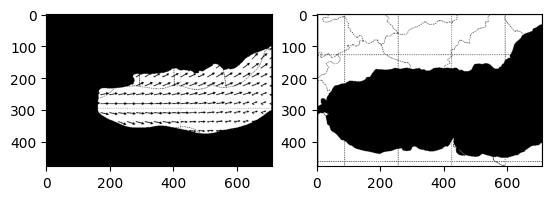

In [13]:
def create_hsv_bounds(hsv, h_delta=10, s_delta=50, v_delta=50):
    h, s, v = hsv[0, 0].astype(np.int16) # unpacking the array. remember it's triple nested
    # converted into uint16 to avoid overflow

    lower_bound = np.array([max(h - h_delta,0), max(s - s_delta,0), max(v - v_delta,0)]).astype(np.uint8)
    upper_bound = np.array([min(h + h_delta,179), min(s + s_delta,255), min(v + v_delta,255)]).astype(np.uint8)
    return lower_bound, upper_bound

def rgb_to_hsv(rgb: list) -> np.ndarray:
    source = np.array(rgb, dtype=np.uint8).reshape(1, 1, 3)
    return cv.cvtColor(source, cv.COLOR_RGB2HSV)

def color_mask(img, color_bounds: tuple[ np.ndarray, np.ndarray]) -> np.ndarray:
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    return cv.inRange(hsv_img, color_bounds[0], color_bounds[1])

yellow_rgb = (255, 255, 110)
y_hsv = rgb_to_hsv(yellow_rgb)
y_lo, y_hi = create_hsv_bounds(y_hsv, 5)
mask_y = color_mask(img, (y_lo, y_hi))

beige_rgb = (255, 227, 173)
b_hsv = rgb_to_hsv(beige_rgb)
b_lo, b_hi = create_hsv_bounds(b_hsv, 5, 20,20)
mask_b = color_mask(img, (b_lo, b_hi))

fig, axes = plt.subplots(1,2)

axes[0].imshow(mask_y, cmap='gray')
axes[1].imshow(mask_b, cmap='gray')
plt.show()
# plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


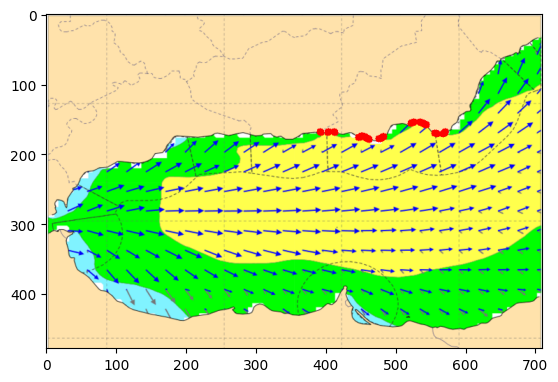

In [14]:

# now let's get the contours and figure out if the shapes are touching

contours_y, _ = cv.findContours(mask_y, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_b, _ = cv.findContours(mask_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

touching = False
touching_points = []
for bc in contours_b:
    for yc in contours_y:
        for bpoint in bc:
            p = (int(bpoint[0][0]), int(bpoint[0][1]))
            dist =  cv.pointPolygonTest(yc, p, True)
            if dist >=-5 and dist < 5:
                touching_points.append(p)



for tp in touching_points:
    cv.circle(img, tp, 5, (0,0,255), -1)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [19]:
import requests
from bs4 import BeautifulSoup
import os

response = requests.get("https://www.aemet.es/es/eltiempo/prediccion/maritima?opc1=0&opc3=0&area=and2")
data = response.text

soup = BeautifulSoup(data, 'html.parser')

images = soup.find_all('img', {"data-src":True})
print(len(images))


os.makedirs("images", exist_ok=True)
for i, image in enumerate(images):
    try:
        response = requests.get(f"https://www.aemet.es/{image['data-src']}")
        response.raise_for_status()
        local_path = f"images/{image['data-src'].split('/')[-1]}"
        with open(local_path, 'wb') as f:
            f.write(response.content)

    except Exception as e:
        print(e)






37
404 Client Error: Not Found for url: https://www.aemet.es//imagenes_d/eltiempo/prediccion/mod_maritima/2024100800+075_aewam_alb_martot.png
404 Client Error: Not Found for url: https://www.aemet.es//imagenes_d/eltiempo/prediccion/mod_maritima/2024100800+078_aewam_alb_martot.png
404 Client Error: Not Found for url: https://www.aemet.es//imagenes_d/eltiempo/prediccion/mod_maritima/2024100800+081_aewam_alb_martot.png
404 Client Error: Not Found for url: https://www.aemet.es//imagenes_d/eltiempo/prediccion/mod_maritima/2024100800+084_aewam_alb_martot.png
404 Client Error: Not Found for url: https://www.aemet.es//imagenes_d/eltiempo/prediccion/mod_maritima/2024100800+087_aewam_alb_martot.png
404 Client Error: Not Found for url: https://www.aemet.es//imagenes_d/eltiempo/prediccion/mod_maritima/2024100800+090_aewam_alb_martot.png
404 Client Error: Not Found for url: https://www.aemet.es//imagenes_d/eltiempo/prediccion/mod_maritima/2024100800+093_aewam_alb_martot.png
404 Client Error: Not Fo

IndexError: index 30 is out of bounds for axis 0 with size 30

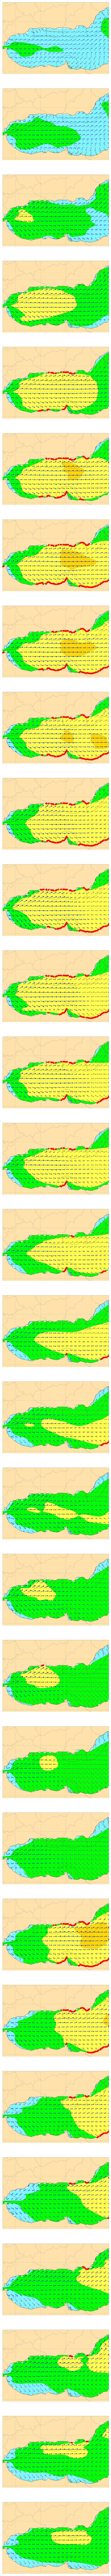

In [18]:

images = sorted(os.listdir("images"))

SWELL_RGB = (255, 255, 110)
LAND_RGB = (255, 227, 173)


fig, axes = plt.subplots(25,1, figsize=(10, 150))

axes = axes.flatten()
for i, img in enumerate(images):
    img_data = cv.imread(f"images/{img}")
    img_data = img_data[22:500, 50:760]
    swell_lo, swell_hi = create_hsv_bounds(rgb_to_hsv(SWELL_RGB), 5)
    swell_mask = color_mask(img_data, (swell_lo, swell_hi))
    land_lo, land_hi = create_hsv_bounds(rgb_to_hsv(LAND_RGB), 5)
    land_mask = color_mask(img_data, (land_lo, land_hi))
    swell_contours, _ = cv.findContours(swell_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    land_contours, _ = cv.findContours(land_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    touching = False
    touching_points = []
    for lc in land_contours:
        for sc in swell_contours:
            for land_point in lc:
                p = (int(land_point[0][0]), int(land_point[0][1]))
                dist =  cv.pointPolygonTest(sc, p, True)
                if dist >=-5 and dist < 5:
                    touching_points.append(p)

    for tp in touching_points:
        cv.circle(img_data, tp, 5, (0,0,255), -1)

    axes[i].imshow(cv.cvtColor(img_data, cv.COLOR_BGR2RGB))
    
    axes[i].axis('off')

plt.show()